# Imports

In [ ]:
!pip install -U scikit-activeml

In [ ]:
import pandas as pd
import numpy as np
import matplotlib as mlp
import matplotlib.pyplot as plt

from sklearn.datasets import load_digits

from skactiveml.pool import UncertaintySampling
from skactiveml.pool import QueryByCommittee

from sklearn.linear_model import LogisticRegression

from sklearn.ensemble import BaggingClassifier
from skactiveml.classifier import SklearnClassifier, ParzenWindowClassifier

from skactiveml.utils import unlabeled_indices, labeled_indices, MISSING_LABEL
from skactiveml.visualization import plot_decision_boundary, plot_utilities

import warnings
mlp.rcParams["figure.facecolor"] = "white"
warnings.filterwarnings("ignore")

# Load and Prepare Data

In [ ]:
data = load_digits()

# Convert to DataFrame
df = pd.DataFrame(data.data, columns=data.feature_names)

# Add target column to the DataFrame
df['target'] = data.target

In [ ]:
df.head()

,pixel_0_0,pixel_0_1,pixel_0_2,pixel_0_3,pixel_0_4,pixel_0_5,pixel_0_6,pixel_0_7,pixel_1_0,pixel_1_1,...,pixel_6_7,pixel_7_0,pixel_7_1,pixel_7_2,pixel_7_3,pixel_7_4,pixel_7_5,pixel_7_6,pixel_7_7,target
0,0.0,0.0,5.0,13.0,9.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,6.0,13.0,10.0,0.0,0.0,0.0,0
1,0.0,0.0,0.0,12.0,13.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,11.0,16.0,10.0,0.0,0.0,1
2,0.0,0.0,0.0,4.0,15.0,12.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,11.0,16.0,9.0,0.0,2
3,0.0,0.0,7.0,15.0,13.0,1.0,0.0,0.0,0.0,8.0,...,0.0,0.0,0.0,7.0,13.0,13.0,9.0,0.0,0.0,3
4,0.0,0.0,0.0,1.0,11.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2.0,16.0,4.0,0.0,0.0,4


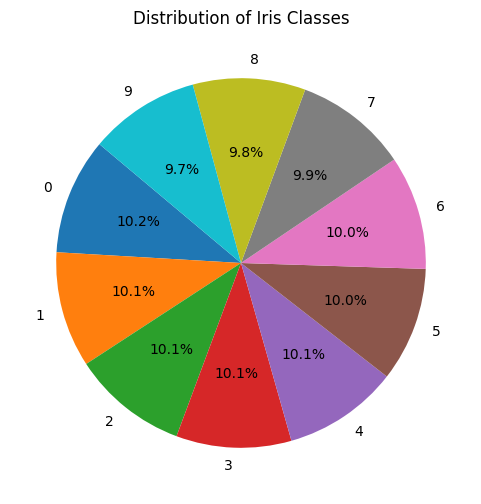

In [ ]:
target_counts = df['target'].value_counts()

plt.figure(figsize=(6, 6))
plt.pie(target_counts, labels=df.target.unique(), autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Iris Classes')
plt.show()

# Entropy

In [ ]:
X = df.drop(columns=['target']).values
y_true = df['target'].values

y = np.full(shape=y_true.shape, fill_value=MISSING_LABEL)

In [ ]:
# clf_entropy = SklearnClassifier(LogisticRegression(), classes=np.unique(y_true))

clf_entropy = ParzenWindowClassifier(classes=np.unique(y_true), random_state=42)
# Initialise the query strategy.
qs_entropy = UncertaintySampling(method='entropy')

In [ ]:
# score on the before querie data.
y = np.full(shape=y_true.shape, fill_value=MISSING_LABEL)
clf_entropy.fit(X, y)

unqueried_score = clf_entropy.score(X,y_true)
print(unqueried_score)

0.10239287701725097


In [ ]:
performance_history_entropy = [unqueried_score]

In [ ]:
n_cycles = 100
for c in range(n_cycles):
  # Fit the classifier.
  clf_entropy.fit(X, y)

  model_accuracy = clf_entropy.score(X,y_true)
  print(f'Query {c+1}: The accuracy score is {model_accuracy}.')

  # Get labeled instances.
  X_labeled = X[labeled_indices(y)]

  # Query the next instance/s.
  query_idx = qs_entropy.query(X=X, y=y, clf=clf_entropy)

  # Label the queried instances.
  y[query_idx] = y_true[query_idx]

  # Save our model's performance for plotting.
  performance_history_entropy.append(model_accuracy)

Query 1: The accuracy score is 0.10239287701725097.
Query 2: The accuracy score is 0.09849749582637729.
Query 3: The accuracy score is 0.1791875347801892.
Query 4: The accuracy score is 0.2632164718976071.
Query 5: The accuracy score is 0.35058430717863104.
Query 6: The accuracy score is 0.43906510851419034.
Query 7: The accuracy score is 0.5013912075681691.
Query 8: The accuracy score is 0.5442404006677797.
Query 9: The accuracy score is 0.6071229827490262.
Query 10: The accuracy score is 0.6321647189760712.
Query 11: The accuracy score is 0.6243739565943238.
Query 12: The accuracy score is 0.6616583194212576.
Query 13: The accuracy score is 0.6638842515303284.
Query 14: The accuracy score is 0.6867000556483027.
Query 15: The accuracy score is 0.6878130217028381.
Query 16: The accuracy score is 0.6956037840845855.
Query 17: The accuracy score is 0.6844741235392321.
Query 18: The accuracy score is 0.6822481914301614.
Query 19: The accuracy score is 0.6883695047301057.
Query 20: The acc

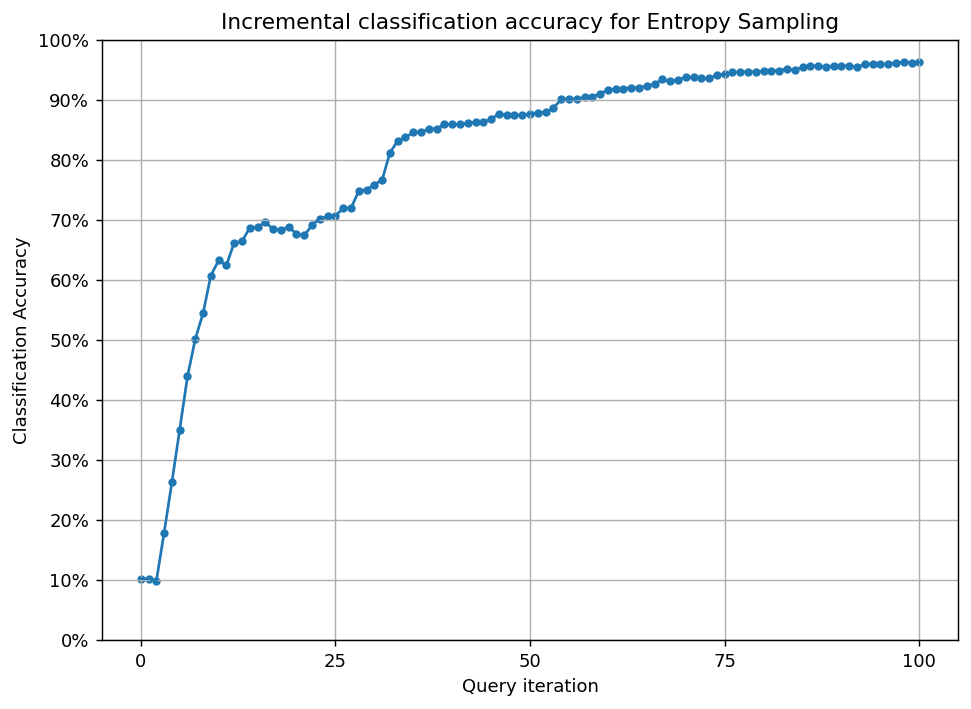

In [ ]:
# Plot our performance over time.
fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)

ax.plot(performance_history_entropy)
ax.scatter(range(len(performance_history_entropy)), performance_history_entropy, s=13)

ax.xaxis.set_major_locator(mlp.ticker.MaxNLocator(nbins=5, integer=True))
ax.yaxis.set_major_locator(mlp.ticker.MaxNLocator(nbins=10))
ax.yaxis.set_major_formatter(mlp.ticker.PercentFormatter(xmax=1))

ax.set_ylim(bottom=0, top=1)
ax.grid(True)

ax.set_title('Incremental classification accuracy for Entropy Sampling')
ax.set_xlabel('Query iteration')
ax.set_ylabel('Classification Accuracy')

plt.show()

# Margin Sampling

In [ ]:
X = df.drop(columns=['target']).values
y_true = df['target'].values

y = np.full(shape=y_true.shape, fill_value=MISSING_LABEL)

In [ ]:
# clf_margin = SklearnClassifier(LogisticRegression(), classes=np.unique(y_true))

clf_margin = ParzenWindowClassifier(classes=np.unique(y_true), random_state=42)
# Initialise the query strategy.
qs_margin = UncertaintySampling(method='margin_sampling')

In [ ]:
# score on the before querie data.
y = np.full(shape=y_true.shape, fill_value=MISSING_LABEL)
clf_margin.fit(X, y)

unqueried_score = clf_margin.score(X,y_true)
print(unqueried_score)

0.10239287701725097


In [ ]:
performance_history_margin = [unqueried_score]

In [ ]:
n_cycles = 100
for c in range(n_cycles):
  # Fit the classifier.
  clf_margin.fit(X, y)

  model_accuracy = clf_margin.score(X,y_true)
  print(f'Query {c+1}: The accuracy score is {model_accuracy}.')

  # Get labeled instances.
  X_labeled = X[labeled_indices(y)]

  # Query the next instance/s.
  query_idx = qs_margin.query(X=X, y=y, clf=clf_margin)

  # Label the queried instances.
  y[query_idx] = y_true[query_idx]

  # Save our model's performance for plotting.
  performance_history_margin.append(model_accuracy)

Query 1: The accuracy score is 0.10239287701725097.
Query 2: The accuracy score is 0.09682804674457429.
Query 3: The accuracy score is 0.17640511964385086.
Query 4: The accuracy score is 0.25208681135225375.
Query 5: The accuracy score is 0.2598775737340011.
Query 6: The accuracy score is 0.2882582081246522.
Query 7: The accuracy score is 0.3761825264329438.
Query 8: The accuracy score is 0.4001112966054535.
Query 9: The accuracy score is 0.44240400667779634.
Query 10: The accuracy score is 0.43906510851419034.
Query 11: The accuracy score is 0.45798553144129106.
Query 12: The accuracy score is 0.46132442960489706.
Query 13: The accuracy score is 0.47356705620478573.
Query 14: The accuracy score is 0.46800222593210905.
Query 15: The accuracy score is 0.5041736227045075.
Query 16: The accuracy score is 0.5470228158041179.
Query 17: The accuracy score is 0.5370061213132999.
Query 18: The accuracy score is 0.563717306622148.
Query 19: The accuracy score is 0.5676126878130217.
Query 20: Th

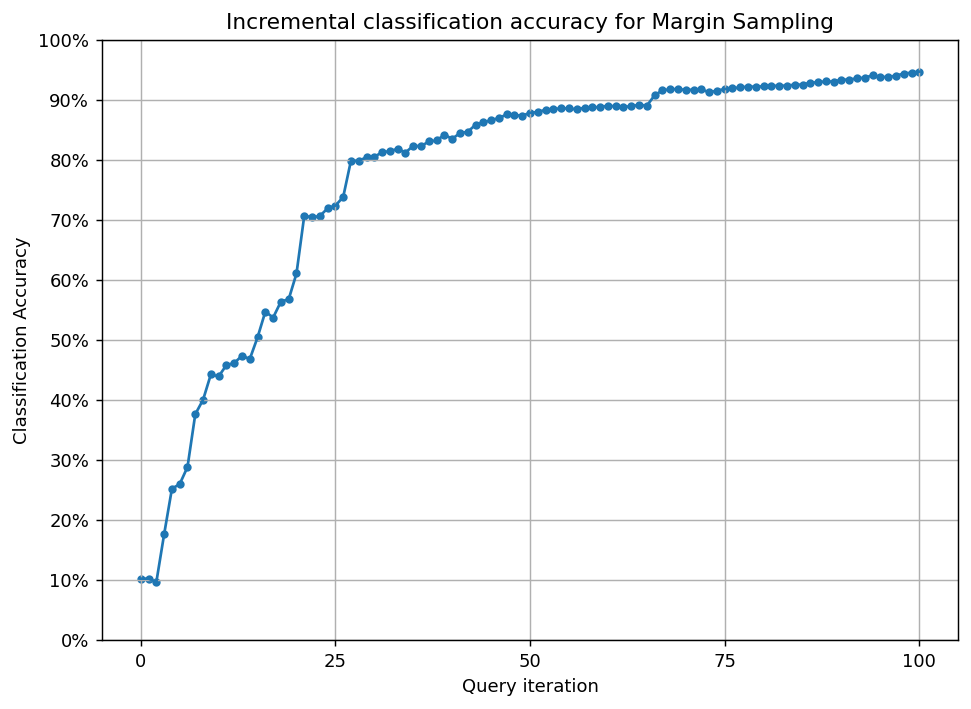

In [ ]:
# Plot our performance over time.
fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)

ax.plot(performance_history_margin)
ax.scatter(range(len(performance_history_margin)), performance_history_margin, s=13)

ax.xaxis.set_major_locator(mlp.ticker.MaxNLocator(nbins=5, integer=True))
ax.yaxis.set_major_locator(mlp.ticker.MaxNLocator(nbins=10))
ax.yaxis.set_major_formatter(mlp.ticker.PercentFormatter(xmax=1))

ax.set_ylim(bottom=0, top=1)
ax.grid(True)

ax.set_title('Incremental classification accuracy for Margin Sampling')
ax.set_xlabel('Query iteration')
ax.set_ylabel('Classification Accuracy')

plt.show()

# Query by Committee

In [ ]:
X = df.drop(columns=['target']).values
y_true = df['target'].values

y = np.full(shape=y_true.shape, fill_value=MISSING_LABEL)

In [ ]:
clf_committee = SklearnClassifier(BaggingClassifier(ParzenWindowClassifier()), classes=np.unique(y_true))

# Initialise the query strategy.
qs_committee = QueryByCommittee(random_state=42)

In [ ]:
# score on the before querie data.
y = np.full(shape=y_true.shape, fill_value=MISSING_LABEL)
clf_committee.fit(X, y)

unqueried_score = clf_committee.score(X,y_true)
print(unqueried_score)

0.09126321647189761


In [ ]:
performance_history_committee = [unqueried_score]

In [ ]:
n_cycles = 100
for c in range(n_cycles):
  # Fit the classifier.
  clf_committee.fit(X, y)

  model_accuracy = clf_committee.score(X,y_true)
  print(f'Query {c+1}: The accuracy score is {model_accuracy}.')

  # Get labeled instances.
  X_labeled = X[labeled_indices(y)]

  # Query the next instance/s.
  query_idx = qs_committee.query(X=X, y=y, ensemble=clf_committee)

  # Label the queried instances.
  y[query_idx] = y_true[query_idx]

  # Save our model's performance for plotting.
  performance_history_committee.append(model_accuracy)

Query 1: The accuracy score is 0.09794101279910963.
Query 2: The accuracy score is 0.10127991096271564.
Query 3: The accuracy score is 0.1547022815804118.
Query 4: The accuracy score is 0.17417918753478018.
Query 5: The accuracy score is 0.17362270450751252.
Query 6: The accuracy score is 0.2442960489705064.
Query 7: The accuracy score is 0.2459654980523094.
Query 8: The accuracy score is 0.30328324986087923.
Query 9: The accuracy score is 0.31775180856983865.
Query 10: The accuracy score is 0.41346688925987757.
Query 11: The accuracy score is 0.4112409571508069.
Query 12: The accuracy score is 0.4741235392320534.
Query 13: The accuracy score is 0.46855870895937674.
Query 14: The accuracy score is 0.48636616583194214.
Query 15: The accuracy score is 0.48636616583194214.
Query 16: The accuracy score is 0.4707846410684474.
Query 17: The accuracy score is 0.5164162493043962.
Query 18: The accuracy score is 0.5347801892042293.
Query 19: The accuracy score is 0.5242070116861436.
Query 20: T

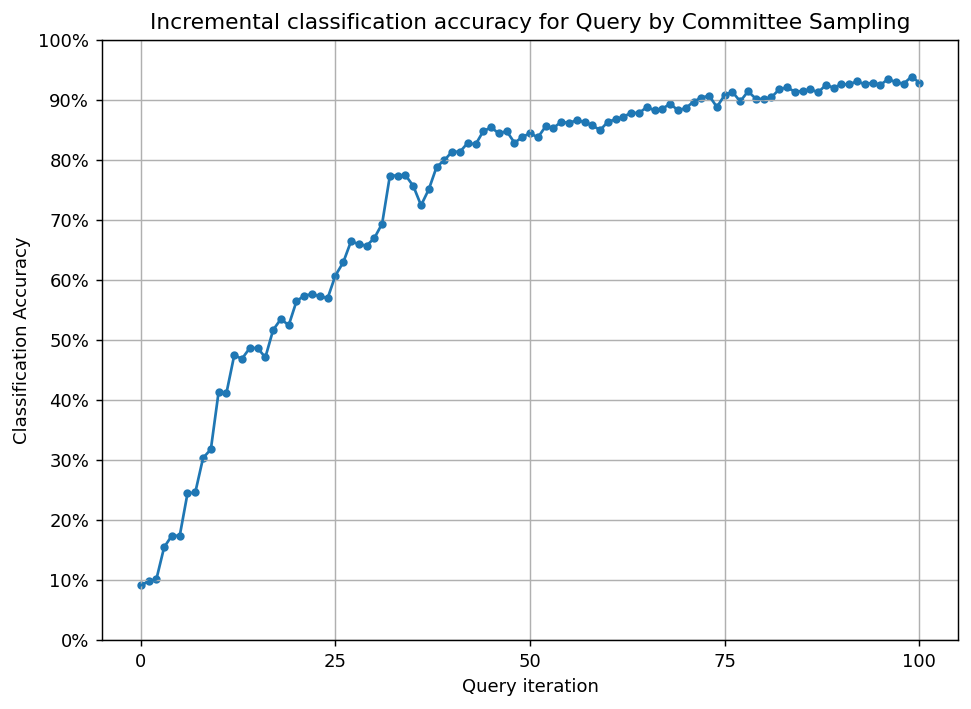

In [ ]:
# Plot our performance over time.
fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)

ax.plot(performance_history_committee)
ax.scatter(range(len(performance_history_committee)), performance_history_committee, s=13)

ax.xaxis.set_major_locator(mlp.ticker.MaxNLocator(nbins=5, integer=True))
ax.yaxis.set_major_locator(mlp.ticker.MaxNLocator(nbins=10))
ax.yaxis.set_major_formatter(mlp.ticker.PercentFormatter(xmax=1))

ax.set_ylim(bottom=0, top=1)
ax.grid(True)

ax.set_title('Incremental classification accuracy for Query by Committee Sampling')
ax.set_xlabel('Query iteration')
ax.set_ylabel('Classification Accuracy')

plt.show()